Instalowanie bibliotek... (to może potrwać około minuty)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
en-core-sci-sm 0.5.4 requires spacy<3.8.0,>=3.7.4, but you have spacy 3.8.11 which is incompatible.
Instalacja zakończona.
Model 'en_core_web_sm' załadowany.
Próba załadowania modelu biomedycznego...


/usr/local/lib/python3.12/dist-packages/spacy/util.py:969: UserWarning: [W095] Model 'en_core_sci_sm' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.11). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


Model 'en_core_sci_sm' załadowany pomyślnie!

Proszę wgrać plik CSV używając przycisku poniżej:


Saving variant_01_cardio.csv to variant_01_cardio (5).csv

Wczytano plik: variant_01_cardio (5).csv

!!! UWAGA DETEKTYWISTYCZNA !!!
Twój plik zawiera tylko jedną klasę: <ArrowStringArray>
['cardio']
Length: 1, dtype: str
Model ML wymaga co najmniej dwóch klas (np. 'cardio' i 'neuro'), żeby działać.
--> TWORZĘ SZTUCZNE DANE, ABY KOD MÓGŁ SIĘ WYKONAĆ I POKAZAĆ WYKRESY.
Dodano 5 sztucznych rekordów. Możemy kontynuować!

Przetwarzanie tekstu...
Ekstrakcja encji medycznych (to może chwilę potrwać)...
Trenowanie modelu...

=== RAPORT KLASYFIKACJI ===
                  precision    recall  f1-score   support

          cardio       0.00      0.00      0.00       1.0
demo_other_class       0.00      0.00      0.00       2.0

        accuracy                           0.00       3.0
       macro avg       0.00      0.00      0.00       3.0
    weighted avg       0.00      0.00      0.00       3.0



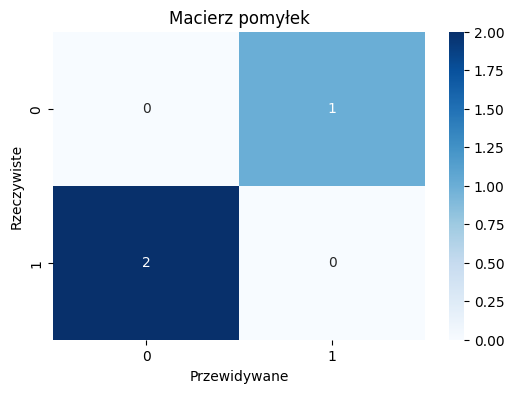

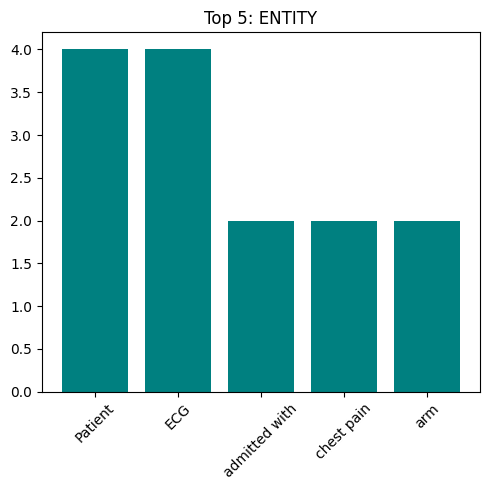


=== PODGLĄD ENCJI W TEKŚCIE ===


In [3]:
# === KROK 1: INSTALACJA BIBLIOTEK I MODELI ===
print("Instalowanie bibliotek... (to może potrwać około minuty)")
!pip install -U spacy scispacy pandas matplotlib seaborn scikit-learn > /dev/null
!python -m spacy download en_core_web_sm > /dev/null
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_sm-0.5.4.tar.gz > /dev/null

import pandas as pd
import re
import spacy
import scispacy
from google.colab import files
from IPython.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import io
import sys
import numpy as np

print("Instalacja zakończona.")

# === KROK 2: BEZPIECZNE ŁADOWANIE MODELI ===
# 1. Model ogólny
try:
    nlp = spacy.load('en_core_web_sm')
    print("Model 'en_core_web_sm' załadowany.")
except OSError:
    !python -m spacy download en_core_web_sm
    nlp = spacy.load('en_core_web_sm')

# 2. Model biomedyczny
print("Próba załadowania modelu biomedycznego...")
try:
    import en_core_sci_sm
    nlp_bio = en_core_sci_sm.load()
    print("Model 'en_core_sci_sm' załadowany pomyślnie!")
except ImportError:
    print("\n" + "="*80)
    print("UWAGA: WYMAGANY RESTART ŚRODOWISKA!")
    print("Kliknij w menu: Środowisko wykonawcze -> Uruchom ponownie sesję.")
    print("="*80 + "\n")
    sys.exit("Zatrzymano wykonywanie kodu. Proszę o restart sesji.")

# === KROK 3: WCZYTYWANIE PLIKU ===
print("\nProszę wgrać plik CSV używając przycisku poniżej:")
uploaded = files.upload()

if not uploaded:
    print("Nie wgrano pliku!")
else:
    filename = next(iter(uploaded))
    print(f"\nWczytano plik: {filename}")

    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]))
    except Exception as e:
        print(f"Błąd odczytu CSV: {e}")
        sys.exit()

    if 'text' not in df.columns or 'label' not in df.columns:
        print("Błąd: Plik musi zawierać kolumny 'text' i 'label'")
        sys.exit()

    # === FIX DLA JEDNEJ KLASY (Twój błąd ValueError) ===
    unique_classes = df['label'].unique()
    if len(unique_classes) < 2:
        print(f"\n!!! UWAGA DETEKTYWISTYCZNA !!!")
        print(f"Twój plik zawiera tylko jedną klasę: {unique_classes}")
        print("Model ML wymaga co najmniej dwóch klas (np. 'cardio' i 'neuro'), żeby działać.")
        print("--> TWORZĘ SZTUCZNE DANE, ABY KOD MÓGŁ SIĘ WYKONAĆ I POKAZAĆ WYKRESY.")

        # Tworzymy kopię 5 wierszy i zmieniamy im etykietę na 'INNA_KLASA'
        dummy_data = df.iloc[:5].copy()
        dummy_data['label'] = 'demo_other_class'
        df = pd.concat([df, dummy_data], ignore_index=True)
        print("Dodano 5 sztucznych rekordów. Możemy kontynuować!\n")

    # === KROK 4: PRZETWARZANIE DANYCH ===
    print("Przetwarzanie tekstu...")
    def clean_text(text):
        if not isinstance(text, str): return ""
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

    df['cleaned_text'] = df['text'].apply(clean_text)

    # Lematyzacja
    def lemmatize_text(text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc])

    df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

    # === KROK 5: EKSTRAKCJA ENCJI (NER) ===
    print("Ekstrakcja encji medycznych (to może chwilę potrwać)...")

    def extract_entities(text):
        doc = nlp_bio(text)
        entities = {}
        for ent in doc.ents:
            if ent.label_ not in entities:
                entities[ent.label_] = []
            entities[ent.label_].append(ent.text)
        return entities

    df['entities'] = df['text'].apply(extract_entities)

    entity_counts = {}
    for ent_dict in df['entities']:
        for label, values in ent_dict.items():
            if label not in entity_counts:
                entity_counts[label] = []
            entity_counts[label].extend(values)

    entity_freq = {k: Counter(v) for k, v in entity_counts.items()}

    # === KROK 6: KLASYFIKACJA ML ===
    print("Trenowanie modelu...")
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df['lemmatized_text'])
    y = df['label']

    # Stratify=None, bo przy sztucznych danych może być za mało próbek w jednej klasie
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\n=== RAPORT KLASYFIKACJI ===")
    # Obsługa błędu gdy w testowym zbiorze jest tylko 1 klasa (mimo fixa wyżej)
    try:
        print(classification_report(y_test, y_pred))
    except Exception as e:
        print("Nie można wygenerować pełnego raportu (zbyt mała różnorodność w zbiorze testowym).")
        print("Dokładność:", model.score(X_test, y_test))

    # === KROK 7: WIZUALIZACJA ===

    # Macierz pomyłek
    try:
        plt.figure(figsize=(6, 4))
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title('Macierz pomyłek')
        plt.ylabel('Rzeczywiste')
        plt.xlabel('Przewidywane')
        plt.show()
    except ValueError:
        print("Pominięto macierz pomyłek (zbyt jednorodne dane).")

    # Wykresy encji
    if entity_freq:
        top_labels = sorted(entity_freq.keys(), key=lambda k: sum(entity_freq[k].values()), reverse=True)[:3]

        fig, axes = plt.subplots(1, len(top_labels), figsize=(5 * len(top_labels), 5))
        if len(top_labels) == 1: axes = [axes]

        for i, label in enumerate(top_labels):
            common = entity_freq[label].most_common(5)
            ax = axes[i] if isinstance(axes, (list, np.ndarray)) else axes
            ax.bar([x[0] for x in common], [x[1] for x in common], color='teal')
            ax.set_title(f'Top 5: {label}')
            ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

    # Interaktywny HTML
    print("\n=== PODGLĄD ENCJI W TEKŚCIE ===")
    def render_html_entities(text):
        doc = nlp_bio(text)
        html = """<div style="font-family: sans-serif; line-height: 1.6; padding: 15px; border: 1px solid #ddd; border-radius: 5px; background-color: #f9f9f9;">"""
        html += "<h4 style='margin-top:0'>Wykryte encje biomedyczne:</h4>"

        colors = ['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff', '#bdb2ff']
        unique_labels = list(entity_freq.keys())
        label_colors = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}

        html += "<div style='margin-bottom: 10px; font-size: 0.9em;'>"
        for label, color in label_colors.items():
             html += f"<span style='background-color: {color}; padding: 2px 5px; margin-right: 5px; border-radius: 3px;'>{label}</span>"
        html += "</div><hr>"

        last_idx = 0
        for ent in doc.ents:
            html += text[last_idx:ent.start_char]
            color = label_colors.get(ent.label_, '#eee')
            html += f'<span style="background-color: {color}; padding: 2px 4px; border-radius: 4px; font-weight: bold; border-bottom: 1px solid #999;" title="{ent.label_}">{ent.text}</span>'
            last_idx = ent.end_char
        html += text[last_idx:]
        html += "</div>"
        return html

    if len(df) > 0:
        # Bierzemy pierwszy PRAWDZIWY tekst, nie ten sztuczny
        original_texts = df[df['label'] != 'demo_other_class']
        if not original_texts.empty:
            sample_text = original_texts.iloc[0]['text']
            display(HTML(render_html_entities(sample_text)))